## Importing and setting up

In [1]:
##### import packages
#base
import os
import sys
from collections import defaultdict
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import random
import pyreadr
import pandas as pd
import seaborn as sns
%matplotlib inline
%autosave 30

#pyro contingency
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete, Predictive
from pyro.ops.indexing import Vindex
from pyro.infer import MCMC, NUTS
import torch
from torch.distributions import constraints
pyro.enable_validation(True)

#misc
import pickle
import torch.nn.functional as F
import itertools
import time
# import umap
# import plotly
# import plotly.graph_objs as go

# import homebrew modules
import models.tomtom_models as tm
import models.tomtom_util as tu

Autosaving every 30 seconds


In [2]:
global tself_norm_all_3d, tself_norm_noauto_3d, tself_raw_all_3d, tself_raw_noauto_3d
global ttarg_norm_all_3d, ttarg_norm_noauto_3d, ttarg_raw_all_3d, ttarg_raw_noauto_3d
global tavg_norm_all_3d, tavg_norm_noauto_3d, tavg_raw_all_3d, tavg_raw_noauto_3d

# import pickled data
with open('data/tomtom_data_preprocessed.pkl','rb') as f:
    [tself_norm_all_3d, tself_norm_noauto_3d, tself_raw_all_3d, tself_raw_noauto_3d,
    ttarg_norm_all_3d, ttarg_norm_noauto_3d, ttarg_raw_all_3d, ttarg_raw_noauto_3d,
    tavg_norm_all_3d, tavg_norm_noauto_3d, tavg_raw_all_3d, tavg_raw_noauto_3d] = pickle.load(f) 

In [3]:
# # import fitted models
# with open('tomtom_fitted_models.pkl','rb') as f:
#     [seeds_self_norm_all_grp,maps_self_norm_all_grp,logprobs_self_norm_all_grp,mems_self_norm_all_grp,
#      seeds_self_norm_all_dim,maps_self_norm_all_dim,logprobs_self_norm_all_dim,
#      seeds_self_norm_noauto_grp,maps_self_norm_noauto_grp,logprobs_self_norm_noauto_grp,mems_self_norm_noauto_grp,
#      seeds_self_norm_noauto_dim,maps_self_norm_noauto_dim,logprobs_self_norm_noauto_dim,
#      seeds_self_raw_all_grp,maps_self_raw_all_grp,logprobs_self_raw_all_grp,mems_self_raw_all_grp,
#      seeds_self_raw_all_dim,maps_self_raw_all_dim,logprobs_self_raw_all_dim,
#      seeds_self_raw_noauto_grp,maps_self_raw_noauto_grp,logprobs_self_raw_noauto_grp,mems_self_raw_noauto_grp,
#      seeds_self_raw_noauto_dim,maps_self_raw_noauto_dim,logprobs_self_raw_noauto_dim] = pickle.load(f)

## fitting models of varying k

currently only fitting self data, swap out the target variable

In [4]:
def fit_varying_k(mtype,target,dtype,auto,maxk):
    tm.mtype = mtype
    tm.target = target # 'self','targ','avg'
    tm.dtype = dtype # 'norm','raw'
    tm.auto = auto # 'noauto','all'
    tm.stickbreak = False
    tm.optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
    tm.elbo = TraceEnum_ELBO(max_plate_nesting=1)
    #dynamically initiate data
    dt = globals()['t{}_{}_{}_3d'.format(target,dtype,auto)]
    seeds = []
    maps = []
    logprobs = []
    mems = []
    if 'gr' in mtype:
        for i in range(1,maxk+1):
            tm.K = i
            seed, mapp, mem, lp = tm.tomtom_svi(dt)
            seeds.append(seed)
            maps.append(mapp)
            logprobs.append(lp)
            mems.append(mem)
        return seeds, maps, logprobs, mems
    elif 'di' in mtype:
        for i in range(1,11):
            tm.K = i
            seed, mapp, lp = tm.tomtom_svi(dt)
            seeds.append(seed)
            maps.append(mapp)
            logprobs.append(lp)
        return seeds,maps,logprobs

In [5]:
maxk = 10
# self, normalized, with autotransitions
seeds_self_norm_all_grp, maps_self_norm_all_grp, logprobs_self_norm_all_grp, mems_self_norm_all_grp =\
    fit_varying_k('grp','self','norm','all',maxk)
seeds_self_norm_all_dim, maps_self_norm_all_dim, logprobs_self_norm_all_dim =\
    fit_varying_k('dim','self','norm','all',maxk)

running SVI with: tself_norm_all_3d
seed = 30, initial_loss = 2419.382080078125
..............................
 final loss: -6295.9462890625

running SVI with: tself_norm_all_3d
seed = 18, initial_loss = 1607.314453125
..............................
 final loss: -6748.98583984375

running SVI with: tself_norm_all_3d
seed = 83, initial_loss = 2155.86474609375
..............................
 final loss: -6685.51708984375

running SVI with: tself_norm_all_3d
seed = 26, initial_loss = 2448.491943359375
..............................
 final loss: -6648.80517578125

running SVI with: tself_norm_all_3d
seed = 21, initial_loss = 1967.4449462890625
..............................
 final loss: -6669.4111328125

running SVI with: tself_norm_all_3d
seed = 25, initial_loss = 2386.95849609375
..............................
 final loss: -6579.013671875

running SVI with: tself_norm_all_3d
seed = 27, initial_loss = 2261.238037109375
..............................
 final loss: -6409.99853515625

running

In [6]:
# self, normalized, no autotransitions
seeds_self_norm_noauto_grp, maps_self_norm_noauto_grp, logprobs_self_norm_noauto_grp, mems_self_norm_noauto_grp =\
    fit_varying_k('grp','self','norm','noauto',maxk)
seeds_self_norm_noauto_dim, maps_self_norm_noauto_dim, logprobs_self_norm_noauto_dim =\
    fit_varying_k('dim','self','norm','noauto',maxk)

running SVI with: tself_norm_noauto_3d
seed = 14, initial_loss = 3685.878662109375
..............................
 final loss: -3498.884765625

running SVI with: tself_norm_noauto_3d
seed = 48, initial_loss = 3041.630859375
..............................
 final loss: -3900.60888671875

running SVI with: tself_norm_noauto_3d
seed = 63, initial_loss = 3330.660888671875
..............................
 final loss: -3872.85400390625

running SVI with: tself_norm_noauto_3d
seed = 40, initial_loss = 3276.39404296875
..............................
 final loss: -3747.674072265625

running SVI with: tself_norm_noauto_3d
seed = 40, initial_loss = 3795.091552734375
..............................
 final loss: -3740.516357421875

running SVI with: tself_norm_noauto_3d
seed = 92, initial_loss = 4015.600341796875
..............................
 final loss: -3651.29541015625

running SVI with: tself_norm_noauto_3d
seed = 26, initial_loss = 4040.1591796875
..............................
 final loss: -35

In [7]:
# self, raw, with autotransitions
seeds_self_raw_all_grp, maps_self_raw_all_grp, logprobs_self_raw_all_grp, mems_self_raw_all_grp =\
    fit_varying_k('grp','self','raw','all',maxk)
seeds_self_raw_all_dim, maps_self_raw_all_dim, logprobs_self_raw_all_dim =\
    fit_varying_k('dim','self','raw','all',maxk)

running SVI with: tself_raw_all_3d
seed = 58, initial_loss = 29378.205078125
..............................
 final loss: -1120.0361328125

running SVI with: tself_raw_all_3d
seed = 31, initial_loss = 28616.029296875
..............................
 final loss: -1154.7095947265625

running SVI with: tself_raw_all_3d
seed = 42, initial_loss = 28270.21875
..............................
 final loss: -1649.3536376953125

running SVI with: tself_raw_all_3d
seed = 98, initial_loss = 28668.017578125
..............................
 final loss: -1326.251220703125

running SVI with: tself_raw_all_3d
seed = 67, initial_loss = 28678.748046875
..............................
 final loss: -1234.5390625

running SVI with: tself_raw_all_3d
seed = 41, initial_loss = 29296.65625
..............................
 final loss: -911.135498046875

running SVI with: tself_raw_all_3d
seed = 88, initial_loss = 28997.82421875
..............................
 final loss: -746.711181640625

running SVI with: tself_raw_a

In [8]:
# self, raw, no autotransitions
seeds_self_raw_noauto_grp, maps_self_raw_noauto_grp, logprobs_self_raw_noauto_grp, mems_self_raw_noauto_grp =\
    fit_varying_k('grp','self','raw','noauto',maxk)
seeds_self_raw_noauto_dim, maps_self_raw_noauto_dim, logprobs_self_raw_noauto_dim =\
    fit_varying_k('dim','self','raw','noauto',maxk)

running SVI with: tself_raw_noauto_3d
seed = 68, initial_loss = 17190.091796875
..............................
 final loss: -937.4014892578125

running SVI with: tself_raw_noauto_3d
seed = 7, initial_loss = 17220.7578125
..............................
 final loss: -1183.563232421875

running SVI with: tself_raw_noauto_3d
seed = 63, initial_loss = 16388.037109375
..............................
 final loss: -1032.616943359375

running SVI with: tself_raw_noauto_3d
seed = 28, initial_loss = 17416.228515625
..............................
 final loss: -859.5875244140625

running SVI with: tself_raw_noauto_3d
seed = 74, initial_loss = 17766.08984375
..............................
 final loss: -708.160400390625

running SVI with: tself_raw_noauto_3d
seed = 31, initial_loss = 17875.974609375
..............................
 final loss: -670.0185546875

running SVI with: tself_raw_noauto_3d
seed = 29, initial_loss = 17596.248046875
..............................
 final loss: -417.381591796875

r

In [9]:
with open('tomtom_fitted_models.pkl','wb') as f:
    pickle.dump([seeds_self_norm_all_grp,maps_self_norm_all_grp,logprobs_self_norm_all_grp,mems_self_norm_all_grp,
                 seeds_self_norm_all_dim,maps_self_norm_all_dim,logprobs_self_norm_all_dim,
                 seeds_self_norm_noauto_grp,maps_self_norm_noauto_grp,logprobs_self_norm_noauto_grp,mems_self_norm_noauto_grp,
                 seeds_self_norm_noauto_dim,maps_self_norm_noauto_dim,logprobs_self_norm_noauto_dim,
                 seeds_self_raw_all_grp,maps_self_raw_all_grp,logprobs_self_raw_all_grp,mems_self_raw_all_grp,
                 seeds_self_raw_all_dim,maps_self_raw_all_dim,logprobs_self_raw_all_dim,
                 seeds_self_raw_noauto_grp,maps_self_raw_noauto_grp,logprobs_self_raw_noauto_grp,mems_self_raw_noauto_grp,
                 seeds_self_raw_noauto_dim,maps_self_raw_noauto_dim,logprobs_self_raw_noauto_dim],f)

## analyze fitted models

analyzing fitted raw_noauto models as an example, but could easily swap out below.

In [10]:
maps_grp = maps_self_raw_noauto_grp
maps_dim = maps_self_raw_noauto_dim
lps_grp = logprobs_self_raw_noauto_grp
lps_dim = logprobs_self_raw_noauto_dim

1) plot the models' log prob as a function of K, grouped by model type

/home/zidong/.conda/envs/tomtom-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/zidong/.conda/envs/tomtom-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

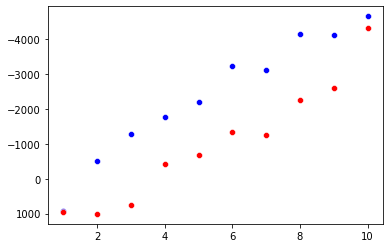

In [11]:
sns.scatterplot(range(1,11),lps_grp, color = 'blue')
sns.scatterplot(range(1,11),lps_dim, color = 'red')

2) analyze how similar grp- and dim-model parameters are as a function of K

In [12]:
# compare parameters from the two models under varying k
meancor = []
meanmaxrow = []
meanmaxcol = []
otorow = []
otocol = []
for i in range(len(maps_self_raw_noauto_grp)):
    cor_mat = tu.grp_dim_param_convergence(map_grp=maps_grp[i],map_dim=maps_dim[i], dtype='raw')
    # get the overall mean of the cormat
    meancor.append(cor_mat['b'].mean())
    # get means of row max and col max
    meanmaxrow.append(cor_mat['b'].max(1).mean())
    meanmaxcol.append(cor_mat['b'].max(0).mean())
    rowindmax, oto = tu.one_to_one_correspondence(cor_mat['b'])
    otorow.append(oto[0]) 
    otocol.append(oto[1]) 

is there evidence that there's one-to-one correspondence (indistinguishable clusters) between the group and the dimensional models?

In [13]:
print(otocol)

[True, True, False, False, False, False, False, False, False, False]


plot mean pair-wise factor parameter correlations as a function of K

alternatives: meamaxcol/meanmaxrow - mean of max parameter correlation per column/row as a function of L

/home/zidong/.conda/envs/tomtom-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Mean pair-wise param corr')

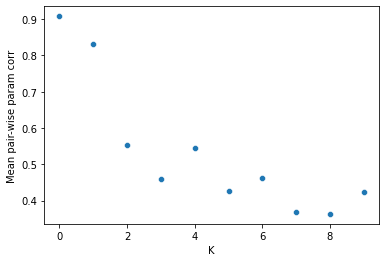

In [14]:
ax = sns.scatterplot(range(10), meancor)
ax.set_xlabel('K')
ax.set_ylabel('Mean pair-wise param corr')